# Odds and Ends in Protein Electrostatics 
_Stefan Hervø-Hansen, Division of Theoretical Chemistry, Lund University._

This notebook is a continuation of intresting topics within protein electrostatics. Topics include the EXG protein and protein engineering in colaboration with Jakob Winther, and topics mentioned at the protein electrostatics meeting 2019 in Telluride, Colorado, USA.


## Import modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import mdtraj as md
from scipy import stats
from scipy import optimize
from adjustText import adjust_text
from simtk.openmm import app
import simtk.openmm as mm
import openmmtools as mmtools
import parmed as pmd

%matplotlib inline

## Energetics of Ion Pairs in Different Dielectrics
This is a very primative model (Coulomb and Born), which predicts the unfavorable process of transfering an ionpair from a high dielectric to a low dielectric.
### Solvation and Electrostatic Energy Function

In [2]:
def BornEnergy(Q, r0, eps=80):
    '''
    Calculates the Born energy of a single ion.
    
    Parameters
    ----------
    Q: float, charge of ion in elementary charges.
    r0: float, radius of ion in angstrøm.
    eps: float, unitless dielectric constant (default: 80).
    
    Example
    ----------
    SolvationEnergy = BornEnergy(-1, 1.75, 50)
    '''
    k = 1.38935406579333*10**(-4) / 2 # [m^2*N/(e^2*mol)], k = Na/(8*pi*epsilon)
    r0 *= 10**(-10)
    return (-k*Q**2/r0) * (1/80 - 1/eps)

def CoulombEnergy(Q1, Q2, r, eps=80):
    '''
    Calculates the Coulomb energy between two ions.
    
    Parameters
    ----------
    Q1: float, charge of ion 1 in elementary charges.
    Q2: float, charge of ion 2 in elementary charges.
    r: float, distance between ion 1 and 2 in angstrøm.
    eps: float, unitless dielectric constant (default: 80).
    
    Example
    ----------
    ElectrostaticEnergy = CoulombEnergy(-1, 1, 3.5, 50)
    '''
    r *= 10**(-10)
    k = 1.38935406579333*10**(-4) #  [m^2*N/(e^2*mol)], k = Na/(4*pi*epsilon)
    return k*(Q1*Q2/(r*eps))

### Do the Calculations

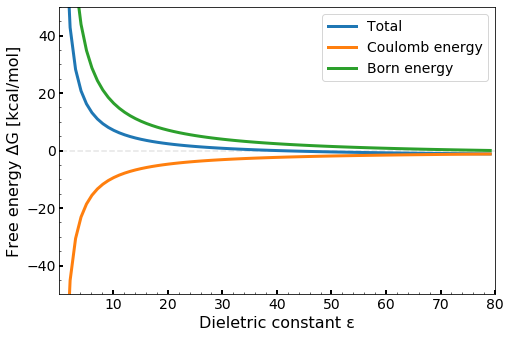

In [3]:
eps_list = np.arange(0.1, 80, 1)
Energy = {
    'Born': [],
    'Coulomb': [],
    'Total': []
}

for eps in eps_list:
    unit_Joule_to_kcal = 2.39*10**(-4)
    E_Coulomb = CoulombEnergy(Q1=1, Q2=-1, r=3.5, eps=eps) * unit_Joule_to_kcal
    E_Born = BornEnergy(Q=1, r0=1.75, eps=eps) * 2 * unit_Joule_to_kcal
    E_Total = E_Coulomb + E_Born
    
    Energy['Coulomb'].append(E_Coulomb)
    Energy['Born'].append(E_Born)
    Energy['Total'].append(E_Total)
    

# Plotting.
fig, ax = plt.subplots(figsize=(6*1.2,4*1.2))

ax.plot(eps_list, Energy['Total'], label='Total', linewidth=3)
ax.plot(eps_list, Energy['Coulomb'], label='Coulomb energy', linewidth=3)
ax.plot(eps_list, Energy['Born'], label='Born energy',  linewidth=3)
ax.hlines(0, -100, 100, alpha=0.1, linestyle='dashed')

# Graphical settings.
ax.minorticks_on()
ax.set_ylim(-50, 50)
ax.set_xlim(0.1, 80)
ax.legend(loc=0, fontsize=14)
ax.set_xlabel('Dieletric constant ε', fontsize=16)
ax.set_ylabel('Free energy ΔG [kcal/mol]', fontsize=16)
ax.tick_params(which='major', direction='in', length=4, width=2, colors='black',
               grid_color='black', grid_alpha=0.5, labelsize=14)
ax.tick_params(which='both', direction='in')

fig.tight_layout()
fig.savefig('figures/Solvation_of_ionpair.pdf', bbox_inches='tight')

## Diprotic acid model: Salt bridge vs Hydrogen bond
The protonation states has been measured for an Asp-His pair in the EXG protein using Monte Carlo simulations. The population of each protonation state as a function of pH is here visaulized.
$$
\begin{equation}
\begin{aligned}
Z &= 1+ e^{-\beta \left( G_{01}^{0} - \mu_{ \mathrm{H}^{+}} \right)}\
+ e^{-\beta \left( G_{10}^{0} - \mu_{ \mathrm{H}^{+}} \right)}\
+ e^{-\beta \left( G_{11}^{0} - 2 \mu_{ \mathrm{H}^{+}} \right)} \\
  &= 1 + 10^{ \left( \mathrm{p}K_{10}^{00} -  \mathrm{pH} \right)} \
+ 10^{ \left( \mathrm{p}K_{01}^{00} -  \mathrm{pH} \right)} \
+ 10^{ \left( \mathrm{p}K_{11}^{10} + \mathrm{p}K_{10}^{00} - 2 \mathrm{pH} \right)}
\end{aligned}
\end{equation}
$$

$$\begin{equation}
\begin{aligned}
\left\langle \left( 00 \right) \right\rangle &= \frac{1}{Z} \\
\left\langle \left( 10 \right) \right\rangle &= \frac{10^{ \left( \mathrm{p}K_{10}^{00} -  \mathrm{pH} \right)}}{Z} \\
\left\langle \left( 01 \right) \right\rangle &= \frac{10^{ \left( \mathrm{p}K_{01}^{00} -  \mathrm{pH} \right)}}{Z} \\
\left\langle \left( 11 \right) \right\rangle &= \frac{10^{ \left( \mathrm{p}K_{11}^{10} + \mathrm{p}K_{10}^{00} - 2 \mathrm{pH} \right)}}{Z}
\end{aligned}
\end{equation}
$$

In [4]:
# Boltzmann weight for each state and the partition function
def QPD(k):
    return 10**(k[0] - pH)
def QDP(k):
    return 10**(k[1] - pH)
def QPP(k):
    return 10**((k[0] + k[1] - k[2]) - 2*pH)
def QDD(k):
    return 1
def Z(k):
    return 1 + QPD(k) + QDP(k) + QPP(k)

# Minimization function
def target(k):
    minimization =  sum((1/Z(k) - DD)**2) + sum((QPD(k)/Z(k) - PD)**2) + sum((QDP(k)/Z(k) - DP)**2) + sum((QPP(k)/Z(k) - PP)**2)
    return minimization

# Write macroscopic function
def macroscopic(pH, pka1, pka2):
    return (10**(pka1 - pH) + 2 * 10**(pka1+pka2 - 2*pH)) / (1+10**(pka1 - pH) + 10**(pka1+pka2 - 2*pH))

Data has been obtained bla bla bla


    Microscopic              Macroscopic
       (2)            (PP)__
    DD ---- DP        (1)   \
(1) |       |  (3)           \__(DP+PD)__
    PD ---- PP                     (2)    \
       (4)                                 \__(DD)

Microscopic pKa values
----------------------
    1: 6.41
    2: 6.66
    3: 3.88
    4: 4.13
    Interaction energy W: 14.60 kJ/mol
    
Macroscopic pKa values
----------------------
    1: 6.85
    2: 3.69



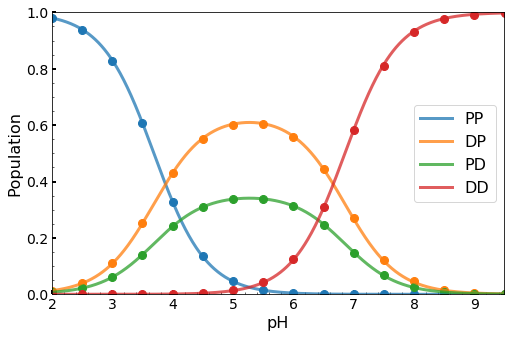

In [5]:
# Load diprotic acid population data
pH, PD, PP, DP, DD, total = np.loadtxt('data/Diprotic_population_EXG_39D66H.dat', usecols=[0,1,2,3,4,5], unpack=True, skiprows=1)
    
result_micro = optimize.minimize(target, x0=np.array([7,4,6]), tol=10**(-10))

result_macro = optimize.curve_fit(macroscopic, pH, total, p0=[3,6])

print('''
    Microscopic              Macroscopic
       (2)            (PP)__
    DD ---- DP        (1)   \\
(1) |       |  (3)           \\__(DP+PD)__
    PD ---- PP                     (2)    \\
       (4)                                 \\__(DD)

Microscopic pKa values
----------------------
    1: {:4.2f}
    2: {:4.2f}
    3: {:4.2f}
    4: {:4.2f}
    Interaction energy W: {:4.2f} kJ/mol
    
Macroscopic pKa values
----------------------
    1: {:4.2f}
    2: {:4.2f}
'''.format(result_micro.x[0], result_micro.x[1], -result_micro.x[2]+result_micro.x[0],
           -result_micro.x[2]+result_micro.x[1], result_micro.x[2]*0.6*np.log(10)*4.18400,
           result_macro[0][0], result_macro[0][1]))

# Plotting
fig, ax = plt.subplots(figsize=(6*1.2, 4*1.2))

# Plot sampled data
ax.plot(pH, PP, marker='o', markersize=8, linestyle='None', color='C0')
ax.plot(pH, DP, marker='o', markersize=8, linestyle='None', color='C1')
ax.plot(pH, PD, marker='o', markersize=8, linestyle='None', color='C2')
ax.plot(pH, DD, marker='o', markersize=8, linestyle='None', color='C3')

# Plot fitted model
pH = np.arange(min(pH), max(pH), 0.01)
ax.plot(pH, QPP(result_micro.x)/Z(result_micro.x), label='PP', linewidth=3, color='C0', alpha=0.75)
ax.plot(pH, QDP(result_micro.x)/Z(result_micro.x), label='DP', linewidth=3, color='C1', alpha=0.75)
ax.plot(pH, QPD(result_micro.x)/Z(result_micro.x), label='PD', linewidth=3, color='C2', alpha=0.75)
ax.plot(pH, QDD(result_micro.x)/Z(result_micro.x), label='DD', linewidth=3, color='C3', alpha=0.75)

# Graphical settings
ax.minorticks_on()
ax.set_ylim(0, 1)
ax.set_xlim(min(pH), max(pH))
ax.legend(loc=0, fontsize=16)
ax.set_xlabel('pH', fontsize=16)
ax.set_ylabel('Population', fontsize=16)
ax.tick_params(which='major', direction='in', length=4, width=2, colors='black',
               grid_color='black', grid_alpha=0.5, labelsize=14)
ax.tick_params(which='minor', direction='in')

fig.tight_layout()
fig.savefig('figures/Diprotic_microstate_population.pdf', bbox_inches='tight')

## pH depedent conformational exchange: diprotic acid
Distance and $\chi_{1}$ angle
### pH-dependent distance distribution
The distance between the titratable sites of the 39D-66H EXG variant has been obtained from the molecular dynamics simulations at different pH. The distrubtions are visualized here.

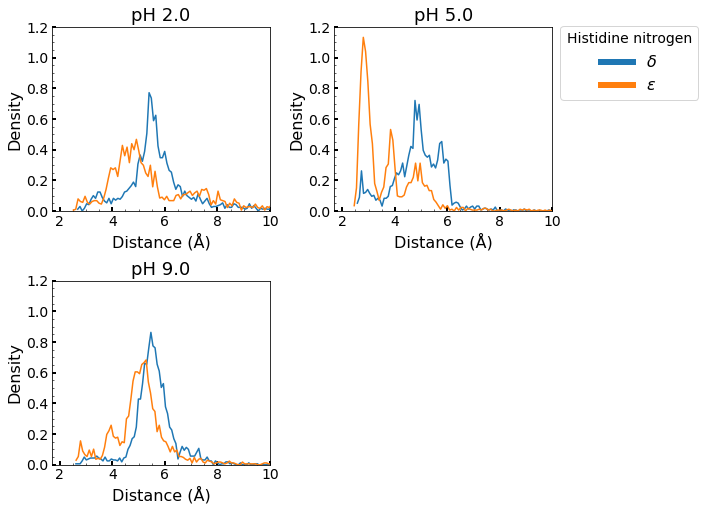

In [6]:
# pH values for which trajectories exists
pHs = [2, 5, 9]

# Initiate figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(1.5*5.5*1.2, 1.5*4*1.2))
axes = [item for sublist in axes for item in sublist]

for i, pH in enumerate(pHs):
    # Load trajecotry
    traj = md.load('trajectories/EXG_39D66H_pH{}.pdb'.format(pH))
    
    coc_dN_dist = []
    coc_eN_dist = []
    
    # Getting index for the indivudal atoms
    asp_oxy = traj.topology.select('(resname AS4 and name OD1) || (resname AS4 and name OD2)') # Aspratate side chain carboxyl oxygen
    his_dN  = traj.topology.select('resname HIS and name ND1') # Histidine side chain imidazole delta nitrogen
    his_eN  = traj.topology.select('resname HIS and name NE2') # Histidine side chain imidazole epsilon nitrogen
    
    for frame in range(traj.n_frames):
        # Calculate center of charge
        coc = (traj.xyz[frame][asp_oxy[0]] + traj.xyz[frame][asp_oxy[1]]) / 2
        
        # Append calculated distances to list
        coc_dN_dist.append(10*np.linalg.norm(coc - traj.xyz[frame][his_dN]))
        coc_eN_dist.append(10*np.linalg.norm(coc - traj.xyz[frame][his_eN]))
     
    for j, distance in enumerate([coc_dN_dist, coc_eN_dist]):
        # Create histogram and plot
        dist_probability, bin_edges_dist = np.histogram(distance, bins=100, density=True)
        bin_centers = (bin_edges_dist[:-1] + bin_edges_dist[1:]) / 2.
        
        if j == 0:
            label = '$\delta$'
        elif j == 1:
            label = '$\epsilon$'
        axes[i].plot(bin_centers, dist_probability, label=label)
        
    axes[i].set_xlim(1.7, 10.0)
    axes[i].set_ylim(0.0, 1.2)
    axes[i].minorticks_on()
    axes[i].set_title('pH {:.1f}'.format(pH), fontsize=18)
    axes[i].set_xlabel('Distance (Å)', fontsize=16)
    axes[i].set_ylabel('Density', fontsize=16)
    #axes[i].legend(loc='upper right', title='Histidine nitrogen', fontsize=14)
    axes[i].tick_params(which='major', direction='in', length=4, width=2, colors='black',
                   grid_color='black', grid_alpha=0.5, labelsize=14)
    axes[i].tick_params(which='minor', direction='in')

# Legend
leg = axes[1].legend(loc='upper left', title='Histidine nitrogen', fontsize=16, bbox_to_anchor=(1.0, 1.05))
for line in leg.get_lines():
    line.set_linewidth(6.0)
leg.get_title().set_fontsize(14)

# Image for 4. graph
#img = mpimg.imread('trajectories/Asp_His_pair_v1_1.png')
#imgplot = axes[3].imshow(img, interpolation='none')
axes[3].axis('off')

# Save figure
fig.tight_layout()
#fig.savefig('figures/Distance_distribution_manual.png', dpi=600, bbox_inches='tight')

### pH-dependent rotamer distribution

/Users/hervoe/miniconda3/lib/python3.7/site-packages/mdtraj/geometry/dihedral.py:374: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(x for x in indices if x.size)[id_sort]


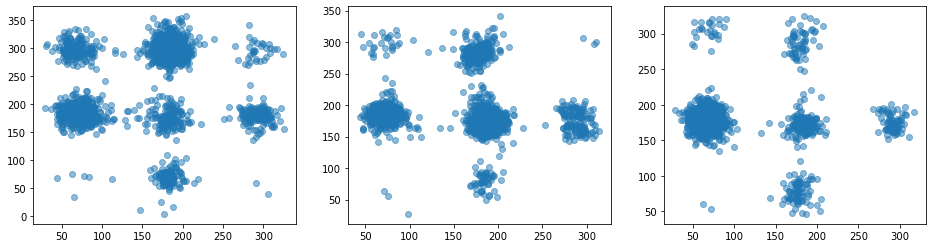

In [7]:
# pH values for which trajectories exists
pHs = [2, 5, 9]

# Initiate figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

for i, pH in enumerate(pHs):
    # Load trajecotry
    traj = md.load('trajectories/EXG_39D66H_pH{}.pdb'.format(pH))
    
    chi1_matrix = md.compute_chi1(traj, periodic=True, opt=True)
    chi1_Asp = np.asarray([np.rad2deg(chi1_matrix[1][i][26]) for i in range(traj.n_frames)]) # 26 is the index for Asp39
    chi1_His = np.asarray([np.rad2deg(chi1_matrix[1][i][49]) for i in range(traj.n_frames)]) # 49 is the index for His66
    chi1_Asp[chi1_Asp < 0] += 360
    chi1_His[chi1_His < 0] += 360
    
    axes[i].scatter(chi1_Asp, chi1_His, alpha=0.5)

## pH depedent conformational exchange: monoprotic single-aspratate residue acid
### pH-dependent rotamer distribution

Progress: Variant 39D, pH 0.5 finished!
Progress: Variant 39D, pH 8.0 finished!
Progress: Variant 43D, pH 0.5 finished!
Progress: Variant 43D, pH 8.0 finished!
Progress: Variant 61D, pH 0.5 finished!
Progress: Variant 61D, pH 8.0 finished!


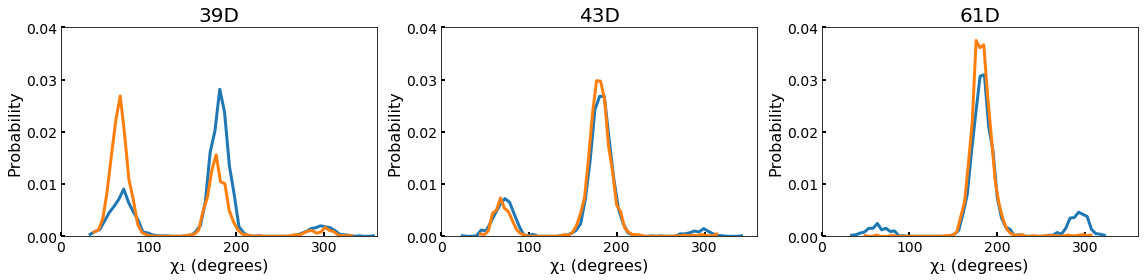

In [8]:
pHs = [0.5, 8.0] # pH values for which trajectories exists
variants = ['39D', '43D', '61D'] # aspartate variants
var_indexes = [26, 30, 46] # index for variants list

# Initiate figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

for i, variant in enumerate(variants):
    j = 0
    for pH in pHs:
        # Load trajecotry
        traj = md.load('trajectories/EXG_{variant}_pH{pH}.pdb'.format(variant=variant, pH=pH))
        
        chi1_matrix = md.compute_chi1(traj, periodic=True, opt=True)
        chi1_Asp = np.asarray([np.rad2deg(chi1_matrix[1][j][var_indexes[i]]) for j in range(traj.n_frames)])
        chi1_Asp[chi1_Asp < 0] += 360
        
        probabilities, edges = np.histogram(chi1_Asp, bins=60, density=True)
        centers = 0.5*(edges[1:]+ edges[:-1])
        axes[i].plot(centers, probabilities, color='C{}'.format(j), linewidth=3)
        print('Progress: Variant {variant}, pH {pH} finished!'.format(variant=variant, pH=pH))
        j+=1
        
for i, ax in enumerate(axes):
    ax.set_xlim(0, 360)
    ax.set_ylim(0, 0.04)
    ax.set_title('{}'.format(variants[i]), fontsize=20)
    ax.set_xlabel('χ₁ (degrees)', fontsize=16)
    ax.set_ylabel('Probability', fontsize=16)
    ax.tick_params(which='major', direction='in', length=4, width=2, colors='black',
                   grid_color='black', grid_alpha=0.5, labelsize=14)
    ax.tick_params(which='minor', direction='in')

fig.tight_layout()
fig.savefig('figures/Asp_sidechain_dihedral.pdf', bbox_inches='tight')

## pKa Prediction of Titratable Residues in a Highly Charge-depleated Protein
Total correlation plot between predicted pKa values by CpHMD simulation and experimental pKa values by NMR spectroscopy for the EXG system.

In [9]:
#### EXG DATA ####

# Experimental pka values
Asp39  = 5
Asp43  = 4.37
Asp61  = 4.15
Asp39d = 4.07
Asp43d = 4.32
Asp61d = 4.1

His66  = 6.39
His66d39 = 7.24
His66d43 = 6.49 
His66d61 = 6.68

exp_asp = [Asp39, Asp43, Asp61, Asp39d, Asp43d, Asp61d]
exp_his = [His66, His66d39, His66d43, His66d61]

# Predicted pka values
sim_Asp39 = 5.33
sim_Asp43 = 4.78
sim_Asp61 = 4.49
sim_Asp39d= 3.69
sim_Asp43d= 4.66
sim_Asp61d= 4.19

sim_His66 = 6.1
sim_His66d39 = 6.85
sim_His66d43 = 6.01
sim_His66d61 = 6.07

sim_asp = [sim_Asp39, sim_Asp43, sim_Asp61, sim_Asp39d, sim_Asp43d, sim_Asp61d]
sim_his = [sim_His66, sim_His66d39, sim_His66d43, sim_His66d61]


label_asp = ['D39', 'D43', 'D61', 'H66-D39', 'H66-D43', 'H66-D61']
label_his = ['H66', 'H66-D39', 'H66-D43', 'H66-D61']

/Users/hervoe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


slope: 1.204133317301808
intercept: -1.0009635163635329
r_value**2: 0.9257400134530535
Root-mean-square error (RMSE) of pKa values: 0.38722086720630133


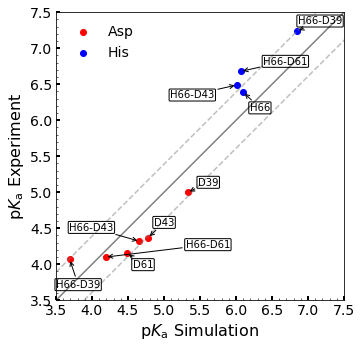

In [10]:
# Begin figure
fig = plt.figure()
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])

texts = []

# Plot
ax.scatter(sim_asp, exp_asp, color='red', label='Asp')
ax.scatter(sim_his, exp_his, color='blue', label='His')

for i, txt in enumerate(label_asp):
    if i > 2:
        weight = 'normal'
    else:
        weight = 'normal'
    text = ax.annotate(txt, (sim_asp[i], exp_asp[i]), weight=weight,
                       bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.1'))
    texts.append(text)
    
for i, txt in enumerate(label_his):
    text = ax.annotate(txt, (sim_his[i], exp_his[i]),
                       bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.1'))
    texts.append(text)


# Statistics and Regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(sim_asp+sim_his,exp_asp+exp_his)
f = lambda x: slope*x + intercept
g = lambda x: x
x = np.array([3.5,10])
#ax.plot(x, f(x), label='Linear fit')
ax.plot(x, g(x), color='black', alpha=0.5)
ax.plot(x, g(x)+0.39, color='gray', alpha=0.5, linestyle='dashed')
ax.plot(x, g(x)-0.39, color='gray', alpha=0.5, linestyle='dashed')

# Axis modification
ax.set_xlim(3.5,7.5)
ax.set_ylim(3.5,7.5)
ax.minorticks_on()
ax.legend(loc=0, fontsize=14, frameon=False)
ax.set_xlabel(r'p$K_{\mathrm{a}}$ Simulation', fontsize=16)
ax.set_ylabel(r'p$K_{\mathrm{a}}$ Experiment', fontsize=16)

ax.set_xticks(np.arange(3.5, 8.0, 0.5))
ax.tick_params(which='major', direction='in', length=4, width=2, colors='black',
               grid_color='black', grid_alpha=0.5, labelsize=14)
ax.tick_params(which='minor', direction='in')
ax.set_aspect('equal')

fig.tight_layout()
# Avoid overlapping annotations
adjust_text(texts, expand_points=(2.0,2.0), expand_text=(2.0, 2.0), expand_align=(2.2, 2.2),
            arrowprops=dict(arrowstyle='->', color='black')) # 1.3,1.3
fig.savefig('figures/Total_pka_correlation.pdf', bbox_inches='tight')

print('slope: {}'.format(slope))
print('intercept: {}'.format(intercept))
print('r_value**2: {}'.format(r_value**2))

sim_full = np.append(sim_asp, sim_his)
exp_full = np.append(exp_asp, exp_his)

pKa_RMSD = np.sqrt(np.sum(np.subtract(sim_full,exp_full)**2)/len(exp_full))
print(r'Root-mean-square error (RMSE) of pKa values: {}'.format(pKa_RMSD))

## Alchemical Transformation of Salt-bridge to Hydrogen-bond

In [ ]:
factory = mmtools.alchemy.AbsoluteAlchemicalFactory(consistent_exceptions=False)

In [ ]:
EXG_hb = pmd.load_file('proton_transfer/EXG_39D66H_hb.parm7', 'proton_transfer/EXG_39D66H_hb.rst7')
EXG_hb_system = EXG_hb.createSystem(nonbondedMethod=app.PME, ewaldErrorTolerance=0.00001,
                                       nonbondedCutoff=1.2*pmd.unit.nanometers, constraints=app.HBonds)

In [4]:
traj = md.load('trajectories/EXG_39D66H_pH2.pdb')
hbonds = md.baker_hubbard(traj, periodic=True)
label = lambda hbond : '%s -- %s' % (traj.topology.atom(hbond[0]), traj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))

ALA1-N -- SER28-OG
GLY3-N -- SER27-OG
GLN5-N -- GLN24-O
GLN5-NE2 -- GLN24-OE1
GLN5-NE2 -- VAL105-O
VAL6-N -- THR104-O
LEU7-N -- THR22-O
GLY9-N -- ASN20-O
ASN11-N -- THR18-O
TRP13-N -- GLY16-O
TRP13-NE1 -- THR15-OG1
GLY16-N -- TRP13-O
PHE17-N -- GLY84-O
THR18-N -- ASN11-O
ALA19-N -- PHE82-O
ASN20-N -- GLY9-O
ASN20-ND2 -- GLN79-OE1
VAL21-N -- PHE80-O
THR22-N -- LEU7-O
VAL23-N -- ALA78-O
GLN24-N -- GLN5-O
GLN24-NE2 -- GLY75-O
ASN25-N -- GLY76-O
ASN25-ND2 -- ALA29-O
ASN25-ND2 -- PRO73-O
THR26-N -- GLY3-O
THR26-N -- GLN24-O
SER27-N -- GLY3-O
SER27-N -- ASN25-OD1
SER27-N -- ASN25-O
SER28-N -- ALA1-O
ALA29-N -- SER27-OG
ALA29-N -- SER27-O
VAL31-N -- ILE72-O
GLY33-N -- GLY70-O
TRP34-N -- ASN65-OD1
TRP34-N -- GLY70-O
TRP34-NE1 -- ASN69-O
LEU36-N -- VAL63-O
THR37-N -- SER97-O
PHE38-N -- VAL61-O
PHE40-N -- SER59-O
SER42-N -- GLN44-OE1
GLY43-N -- PHE40-O
GLN44-N -- GLN44-OE1
GLN44-NE2 -- ALA91-O
GLN44-NE2 -- ASN90-OD1
GLN45-N -- SER85-O
GLN45-NE2 -- GLY58-O
GLN45-NE2 -- GLY43-O
VAL46-N -- GLN56-OE

In [5]:
traj = md.load('trajectories/EXG_39D66H_pH5.pdb')
hbonds = md.baker_hubbard(traj, periodic=True)
label = lambda hbond : '%s -- %s' % (traj.topology.atom(hbond[0]), traj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))

GLY3-N -- SER27-OG
GLN5-N -- GLN24-O
GLN5-NE2 -- GLN24-OE1
GLN5-NE2 -- VAL105-O
VAL6-N -- THR104-O
LEU7-N -- THR22-O
GLY9-N -- ASN20-O
ASN11-N -- THR18-O
TRP13-N -- GLY16-O
TRP13-NE1 -- THR15-OG1
GLY16-N -- TRP13-O
PHE17-N -- GLY84-O
THR18-N -- ASN11-O
ALA19-N -- PHE82-O
ASN20-N -- GLY9-O
ASN20-ND2 -- GLN79-OE1
ASN20-ND2 -- GLN79-NE2
VAL21-N -- PHE80-O
THR22-N -- LEU7-O
VAL23-N -- ALA78-O
GLN24-N -- GLN5-O
GLN24-NE2 -- GLY75-O
ASN25-N -- GLY76-O
ASN25-ND2 -- ALA29-O
ASN25-ND2 -- PRO73-O
THR26-N -- GLY3-O
THR26-N -- GLN24-O
SER27-N -- GLY3-O
SER27-N -- ASN25-OD1
SER27-N -- ASN25-O
SER28-N -- ALA1-O
ALA29-N -- SER27-OG
ALA29-N -- SER27-O
VAL31-N -- ILE72-O
GLY33-N -- GLY70-O
TRP34-N -- ASN65-OD1
TRP34-N -- GLY70-O
TRP34-NE1 -- ASN69-O
LEU36-N -- VAL63-O
THR37-N -- SER97-O
PHE38-N -- VAL61-O
PHE40-N -- SER59-O
SER42-N -- GLN44-OE1
GLY43-N -- PHE40-O
GLN44-N -- GLN44-OE1
GLN44-NE2 -- ALA91-O
GLN44-NE2 -- ASN90-OD1
GLN45-N -- SER85-O
GLN45-NE2 -- GLY58-O
GLN45-NE2 -- GLY43-O
VAL46-N -- GLN5